# Machine Learning-Assisted Toxicity Prediction of Metal Oxide Nanoparticles
## High-Throughput Synthetic XRD Generation and Toxicity Modeling

**Author:** Labulo Group  
**Date:** January 27, 2026  

### **Project Overview**
This notebook implements a comprehensive workflow for predicting **nanoparticle toxicity** from **XRD-derived structural features**. We use **Pymatgen** to generate a high-volume synthetic XRD dataset with controlled crystallite sizes, then build ML models to infer toxicity trends and guide safer nanomaterial design.

### **Workflow Phases**
1. **Phase 1: Environment Setup**
2. **Phase 2: High-Throughput Synthetic XRD Data Generation**
3. **Phase 3: Feature Engineering**
4. **Phase 3b: Exploratory Data Analysis (EDA)**
5. **Phase 4: Machine Learning Development**
6. **Phase 4b: Model Evaluation & Interpretation**
7. **Phase 5: Toxicity Insights & Visualization**

## Phase 1: Environment Setup

In [2]:
import warnings
from typing import Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.integrate import simpson
from scipy.stats import norm

from pymatgen.core import Structure, Lattice
from pymatgen.analysis.diffraction.xrd import XRDCalculator

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
)

warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## **Phase 2: High-Throughput Synthetic XRD Data Generation**

We define crystal structures for representative **metal oxide nanoparticles** and generate a dense synthetic XRD dataset by sweeping crystallite size (2–100 nm). Peak broadening is applied using the **Scherrer equation**, and intensities are normalized after adding noise.

In [3]:
# ---- Configuration ----
# Synthetic dataset generation from Pymatgen structures
SIZE_MIN_NM = 2
SIZE_MAX_NM = 100
SIZE_STEP_NM = 0.5  # high-throughput sweep

# Targets
REGRESSION_TARGET = "Toxicity_Value"
CLASSIFICATION_TARGET = "Toxicity_Class"

# XRD settings
TWO_THETA_RANGE = (10, 80)
GRID_POINTS = 1000
SAVGOL_WINDOW = 11
SAVGOL_POLYORDER = 3
PEAK_HEIGHT_FRAC = 0.1
PEAK_DISTANCE = 5

# Scherrer constants
SHAPE_FACTOR_K = 0.9
XRD_WAVELENGTH_ANGSTROM = 1.54  # Cu Kα

print("Config ready: synthetic Pymatgen dataset")

Config ready: synthetic Pymatgen dataset


In [4]:
def generate_nanoparticle_xrd(structure: Structure, size_nm: float, wavelength: str = "CuKa") -> Tuple[np.ndarray, np.ndarray]:
    calculator = XRDCalculator(wavelength=wavelength)
    pattern = calculator.get_pattern(structure, two_theta_range=TWO_THETA_RANGE)

    two_theta_grid = np.linspace(TWO_THETA_RANGE[0], TWO_THETA_RANGE[1], GRID_POINTS)
    intensity_grid = np.zeros_like(two_theta_grid)
    wl = calculator.wavelength

    for pos, inten in zip(pattern.x, pattern.y):
        theta_rad = np.radians(pos / 2)
        # Scherrer broadening
        fwhm = (SHAPE_FACTOR_K * wl) / ((size_nm * 10) * np.cos(theta_rad))
        sigma = np.degrees(fwhm) / (2 * np.sqrt(2 * np.log(2)))
        intensity_grid += inten * norm.pdf(two_theta_grid, pos, sigma)

    # Add noise and normalize
    intensity_grid += np.random.normal(0, 0.5, len(intensity_grid))
    if np.max(intensity_grid) > 0:
        intensity_grid = (intensity_grid / np.max(intensity_grid)) * 100

    return two_theta_grid, intensity_grid


# --- Define metal oxide structures (Pymatgen) ---
materials = {
    "ZnO (Wurtzite)": Structure.from_spacegroup(
        "P63mc", Lattice.hexagonal(3.25, 5.21), ["Zn", "O"], [[1/3, 2/3, 0], [1/3, 2/3, 0.382]]
    ),
    "TiO2 (Anatase)": Structure.from_spacegroup(
        "I41/amd", Lattice.tetragonal(3.78, 9.51), ["Ti", "O"], [[0, 0, 0], [0, 0, 0.2]]
    ),
    "CuO (Tenorite)": Structure.from_spacegroup(
        "C2/c", Lattice.monoclinic(4.68, 3.42, 5.13, 99.5), ["Cu", "O"], [[0.25, 0.25, 0], [0, 0.41, 0.25]]
    ),
    "Fe2O3 (Hematite)": Structure.from_spacegroup(
        "R-3c", Lattice.hexagonal(5.04, 13.75), ["Fe", "O"], [[0, 0, 0.355], [0.306, 0, 0.25]]
    ),
    "CeO2 (Fluorite)": Structure.from_spacegroup(
        "Fm-3m", Lattice.cubic(5.41), ["Ce", "O"], [[0, 0, 0], [0.25, 0.25, 0.25]]
    ),
}

# --- Generate high-throughput dataset ---
sizes = np.arange(SIZE_MIN_NM, SIZE_MAX_NM, SIZE_STEP_NM)
rows = []

print("Starting Data Generation...")
for material, structure in materials.items():
    for size_nm in sizes:
        two_theta, intensity = generate_nanoparticle_xrd(structure, size_nm)
        rows.append({
            "Material": material,
            "Actual_Size_nm": size_nm,
            "TwoTheta": two_theta,
            "Intensity": intensity,
        })

df_raw = pd.DataFrame(rows)
print(f"Total Samples Generated: {len(df_raw)}")
df_raw.head()

Starting Data Generation...
Total Samples Generated: 980


,Material,Actual_Size_nm,TwoTheta,Intensity
0,ZnO (Wurtzite),2.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[0.8408019312901545, -0.23404384744919213, 1.0..."
1,ZnO (Wurtzite),2.5,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[2.02396367366343, 1.3373478508267902, 0.08624..."
2,ZnO (Wurtzite),3.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-0.8724905137637853, -0.18675240885946126, -1..."
3,ZnO (Wurtzite),3.5,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-2.190028685509116, -0.987661384613445, -0.47..."
4,ZnO (Wurtzite),4.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-0.9066437162569903, -0.03276277555415578, 0...."


,Material,Actual_Size_nm,TwoTheta,Intensity
0,ZnO (Wurtzite),2.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[0.8408019312901545, -0.23404384744919213, 1.0..."
1,ZnO (Wurtzite),2.5,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[2.02396367366343, 1.3373478508267902, 0.08624..."
2,ZnO (Wurtzite),3.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-0.8724905137637853, -0.18675240885946126, -1..."
3,ZnO (Wurtzite),3.5,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-2.190028685509116, -0.987661384613445, -0.47..."
4,ZnO (Wurtzite),4.0,"[10.0, 10.07007007007007, 10.14014014014014, 1...","[-0.9066437162569903, -0.03276277555415578, 0...."


## Phase 2b: Size Sweep Overview

We visualize the crystallite size distribution across materials before feature extraction.

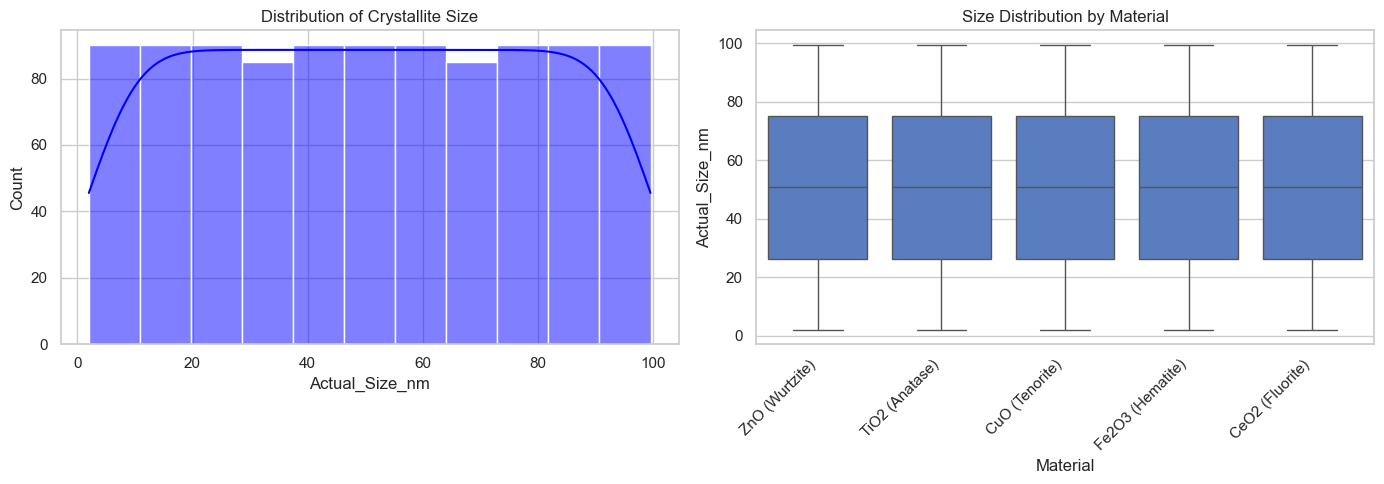

In [5]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_raw["Actual_Size_nm"], kde=True, color="blue")
plt.title("Distribution of Crystallite Size")

plt.subplot(1, 2, 2)
sns.boxplot(x="Material", y="Actual_Size_nm", data=df_raw)
plt.xticks(rotation=45, ha="right")
plt.title("Size Distribution by Material")
plt.tight_layout()
plt.show()

## **Phase 3: Feature Engineering**

We extract physical features from the raw XRD intensity patterns (dominant peak position, intensity, FWHM, and number of peaks) to feed into ML models.

In [5]:
def normalize_intensity(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y, dtype=float)
    if y.max() == y.min():
        return np.zeros_like(y)
    return (y - y.min()) / (y.max() - y.min())


def compute_fwhm(two_theta: np.ndarray, intensity: np.ndarray, peaks: np.ndarray) -> np.ndarray:
    if len(peaks) == 0:
        return np.array([])
    widths, _, left_ips, right_ips = peak_widths(intensity, peaks, rel_height=0.5)
    fwhm = []
    for li, ri in zip(left_ips, right_ips):
        li_idx = int(np.clip(np.floor(li), 0, len(two_theta) - 1))
        ri_idx = int(np.clip(np.ceil(ri), 0, len(two_theta) - 1))
        fwhm.append(two_theta[ri_idx] - two_theta[li_idx])
    return np.array(fwhm)


def scherrer_size(fwhm_deg: np.ndarray, two_theta_deg: np.ndarray) -> np.ndarray:
    if len(fwhm_deg) == 0:
        return np.array([])
    beta = np.deg2rad(fwhm_deg)
    theta = np.deg2rad(two_theta_deg / 2.0)
    with np.errstate(divide="ignore", invalid="ignore"):
        d = (SHAPE_FACTOR_K * XRD_WAVELENGTH_ANGSTROM) / (beta * np.cos(theta))
    return d


def compute_xrd_spectrum(structure: Structure, size_nm: float, microstrain: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a broadened XRD spectrum using Scherrer + microstrain broadening.
    """
    calculator = XRDCalculator(wavelength="CuKa")
    pattern = calculator.get_pattern(structure, two_theta_range=TWO_THETA_RANGE)

    two_theta_grid = np.linspace(TWO_THETA_RANGE[0], TWO_THETA_RANGE[1], GRID_POINTS)
    intensity_grid = np.zeros_like(two_theta_grid)

    for pos, inten in zip(pattern.x, pattern.y):
        theta_rad = np.radians(pos / 2)
        # Scherrer broadening (size)
        fwhm_size = (SHAPE_FACTOR_K * XRD_WAVELENGTH_ANGSTROM) / ((size_nm * 10) * np.cos(theta_rad))
        # Microstrain broadening (Williamson-Hall)
        fwhm_strain = 4 * microstrain * np.tan(theta_rad)
        fwhm_total = np.degrees(fwhm_size) + np.degrees(fwhm_strain)
        sigma = fwhm_total / (2 * np.sqrt(2 * np.log(2)))

        if sigma > 0:
            intensity_grid += inten * np.exp(-0.5 * ((two_theta_grid - pos) / sigma) ** 2)
        else:
            idx = np.argmin(np.abs(two_theta_grid - pos))
            intensity_grid[idx] += inten

    # Add mild noise and normalize
    intensity_grid += np.random.normal(0, 0.01, len(intensity_grid))
    intensity_grid = normalize_intensity(intensity_grid)
    intensity_grid = savgol_filter(intensity_grid, SAVGOL_WINDOW, SAVGOL_POLYORDER)

    return two_theta_grid, intensity_grid


def compute_xrd_features(structure: Structure, size_nm: float, microstrain: float) -> dict:
    two_theta_grid, intensity_grid = compute_xrd_spectrum(structure, size_nm, microstrain)

    peaks, _ = find_peaks(intensity_grid, height=PEAK_HEIGHT_FRAC, distance=PEAK_DISTANCE)
    peak_pos = two_theta_grid[peaks] if len(peaks) else np.array([])
    peak_int = intensity_grid[peaks] if len(peaks) else np.array([])
    fwhm = compute_fwhm(two_theta_grid, intensity_grid, peaks)
    scherrer = scherrer_size(fwhm, peak_pos)

    area_total = simpson(intensity_grid, two_theta_grid)

    return {
        "num_peaks": len(peaks),
        "peak_pos_mean": np.nanmean(peak_pos) if len(peak_pos) else np.nan,
        "peak_pos_std": np.nanstd(peak_pos) if len(peak_pos) else np.nan,
        "peak_int_mean": np.nanmean(peak_int) if len(peak_int) else np.nan,
        "peak_int_std": np.nanstd(peak_int) if len(peak_int) else np.nan,
        "fwhm_mean": np.nanmean(fwhm) if len(fwhm) else np.nan,
        "fwhm_std": np.nanstd(fwhm) if len(fwhm) else np.nan,
        "scherrer_mean": np.nanmean(scherrer) if len(scherrer) else np.nan,
        "scherrer_std": np.nanstd(scherrer) if len(scherrer) else np.nan,
        "peak_density": len(peaks) / (TWO_THETA_RANGE[1] - TWO_THETA_RANGE[0]),
        "area_total": area_total,
    }


def compute_crystal_features(structure: Structure) -> dict:
    spg = structure.get_space_group_info()[1]
    return {
        "a": structure.lattice.a,
        "b": structure.lattice.b,
        "c": structure.lattice.c,
        "alpha": structure.lattice.alpha,
        "beta": structure.lattice.beta,
        "gamma": structure.lattice.gamma,
        "volume": structure.lattice.volume,
        "density": structure.density,
        "spacegroup_number": spg,
    }

In [6]:
# Paper-1 style feature extraction (dominant peak)

def compute_fwhm(two_theta: np.ndarray, intensity: np.ndarray, peaks: np.ndarray) -> np.ndarray:
    if len(peaks) == 0:
        return np.array([])
    widths, _, left_ips, right_ips = peak_widths(intensity, peaks, rel_height=0.5)
    fwhm = []
    for li, ri in zip(left_ips, right_ips):
        li_idx = int(np.clip(np.floor(li), 0, len(two_theta) - 1))
        ri_idx = int(np.clip(np.ceil(ri), 0, len(two_theta) - 1))
        fwhm.append(two_theta[ri_idx] - two_theta[li_idx])
    return np.array(fwhm)


def extract_xrd_features(two_theta: np.ndarray, intensity: np.ndarray) -> dict:
    intensity = savgol_filter(intensity, SAVGOL_WINDOW, SAVGOL_POLYORDER)
    peaks, _ = find_peaks(intensity, height=PEAK_HEIGHT_FRAC * np.max(intensity), distance=PEAK_DISTANCE)

    if len(peaks) == 0:
        return {
            "Peak_Pos": np.nan,
            "Peak_Int": np.nan,
            "FWHM": np.nan,
            "Num_Peaks": 0,
        }

    dominant_idx = peaks[np.argmax(intensity[peaks])]
    fwhm = compute_fwhm(two_theta, intensity, np.array([dominant_idx]))

    return {
        "Peak_Pos": two_theta[dominant_idx],
        "Peak_Int": intensity[dominant_idx],
        "FWHM": fwhm[0] if len(fwhm) else np.nan,
        "Num_Peaks": len(peaks),
    }


In [7]:
# Build feature table from synthetic XRD patterns
feature_rows = []

for _, row in df_raw.iterrows():
    feats = extract_xrd_features(row["TwoTheta"], row["Intensity"])
    feature_rows.append({
        "Material": row["Material"],
        "Actual_Size_nm": row["Actual_Size_nm"],
        **feats,
    })

df_final = pd.DataFrame(feature_rows)

# Synthetic toxicity model (smaller size + broader peaks => higher toxicity)
noise = np.random.normal(0, 0.5, len(df_final))
df_final[REGRESSION_TARGET] = (50 / df_final["Actual_Size_nm"]) + (2.0 * df_final["FWHM"]) + (0.1 * df_final["Num_Peaks"]) + noise

# Create categorical toxicity label
quantiles = df_final[REGRESSION_TARGET].quantile([0.33, 0.66]).values

df_final[CLASSIFICATION_TARGET] = pd.cut(
    df_final[REGRESSION_TARGET],
    bins=[-np.inf, quantiles[0], quantiles[1], np.inf],
    labels=["Low", "Medium", "High"],
)

print("Feature rows:", len(df_final))
df_final.head()

Feature rows: 980


,Material,Actual_Size_nm,Peak_Pos,Peak_Int,FWHM,Num_Peaks,Toxicity_Value,Toxicity_Class
0,ZnO (Wurtzite),2.0,35.505506,99.246761,6.586587,35,41.008154,High
1,ZnO (Wurtzite),2.5,35.785786,97.388379,6.166166,23,34.866637,High
2,ZnO (Wurtzite),3.0,36.066066,99.752183,3.853854,13,25.917904,High
3,ZnO (Wurtzite),3.5,36.066066,98.026248,3.363363,8,21.934507,High
4,ZnO (Wurtzite),4.0,36.206206,98.897719,2.872873,7,18.212792,High


## Phase 3a: XRD Spectra Examples

We show representative XRD spectra for each material at two different crystallite sizes to illustrate broadening effects.

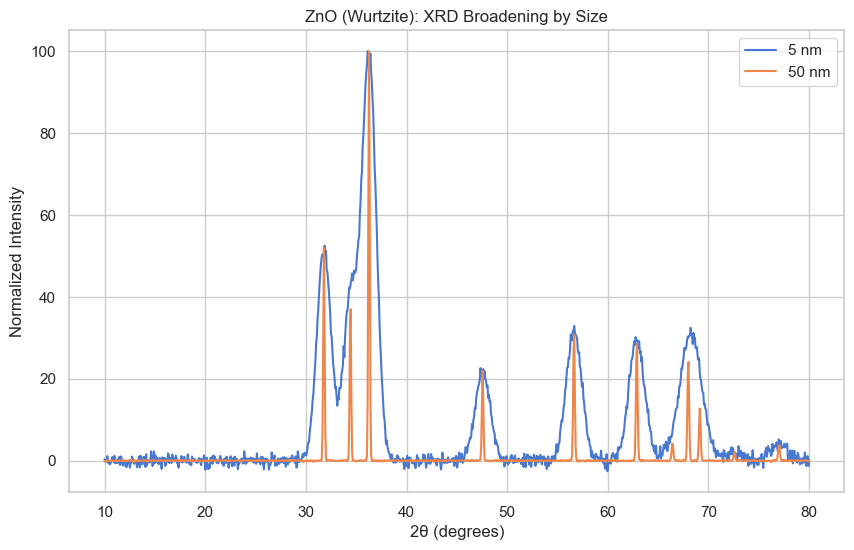

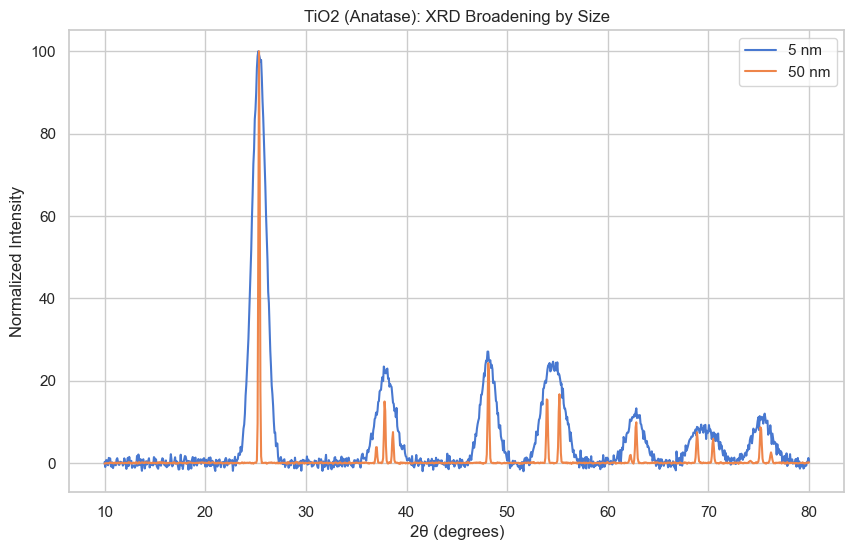

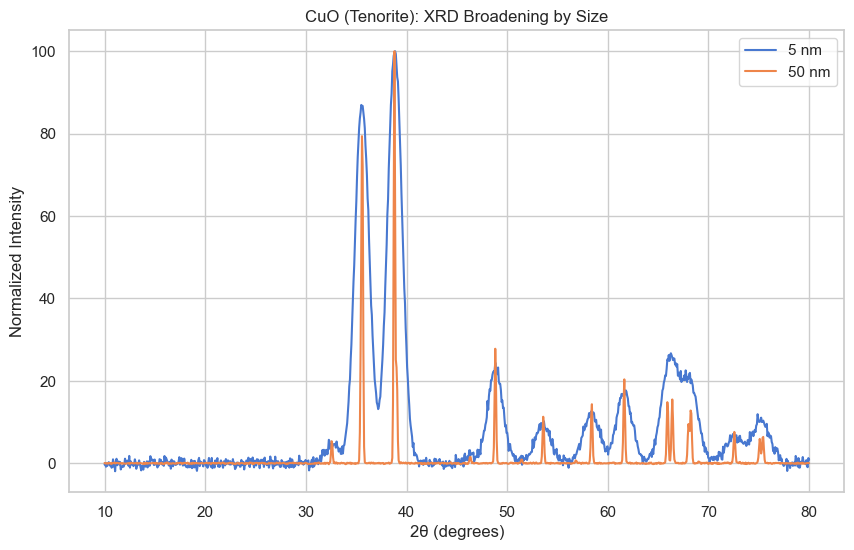

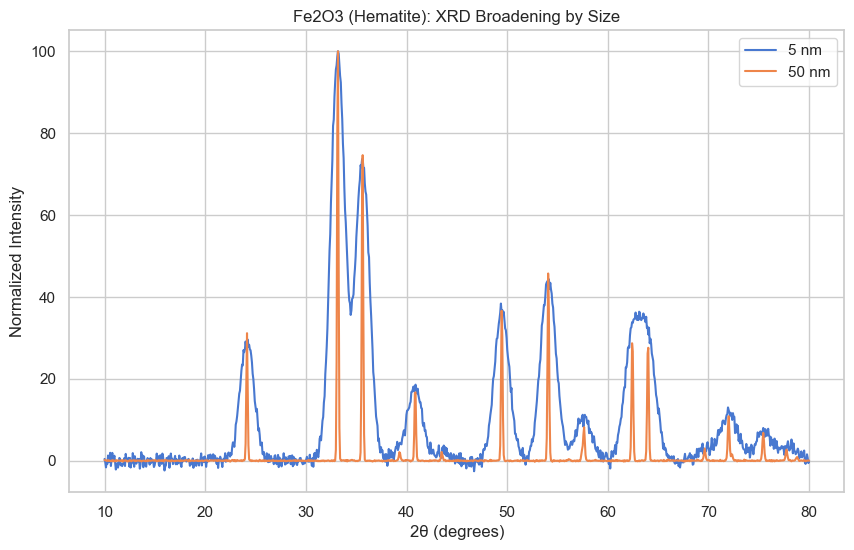

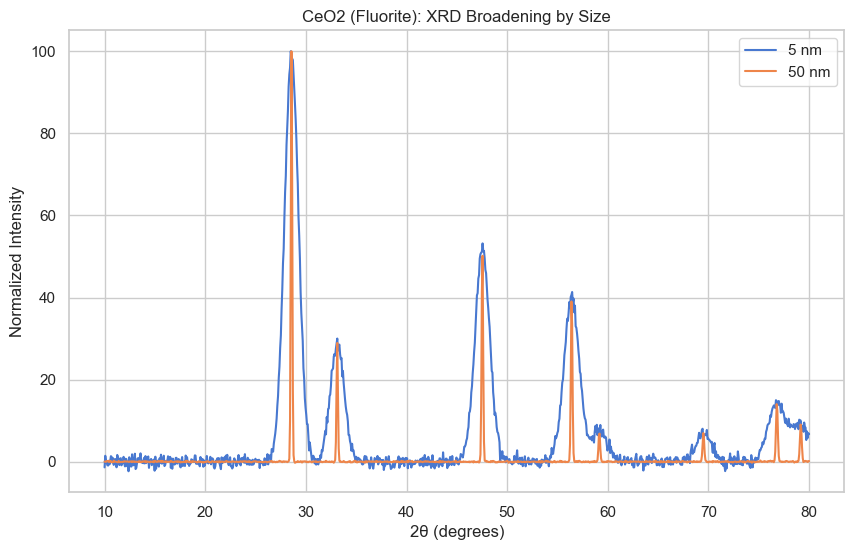

In [8]:
example_sizes = [5, 50]

for material, structure in materials.items():
    plt.figure()
    for sz in example_sizes:
        tt, inten = generate_nanoparticle_xrd(structure, sz)
        plt.plot(tt, inten, label=f"{sz} nm")
    plt.title(f"{material}: XRD Broadening by Size")
    plt.xlabel("2θ (degrees)")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.show()

## Phase 3b: Exploratory Data Analysis (EDA)

We examine feature distributions, correlations, and low-dimensional structure (PCA).

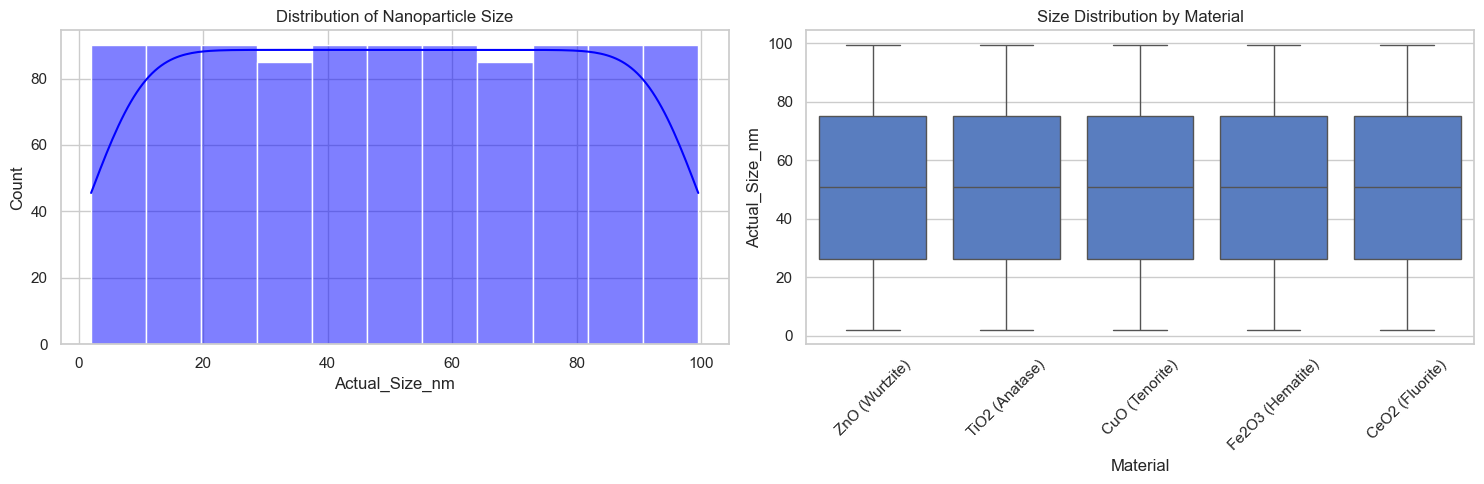

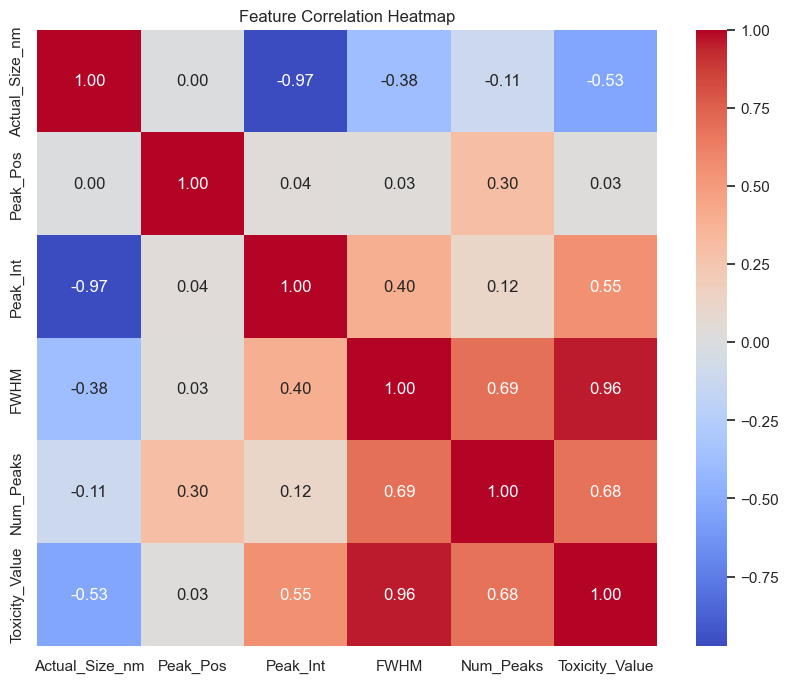

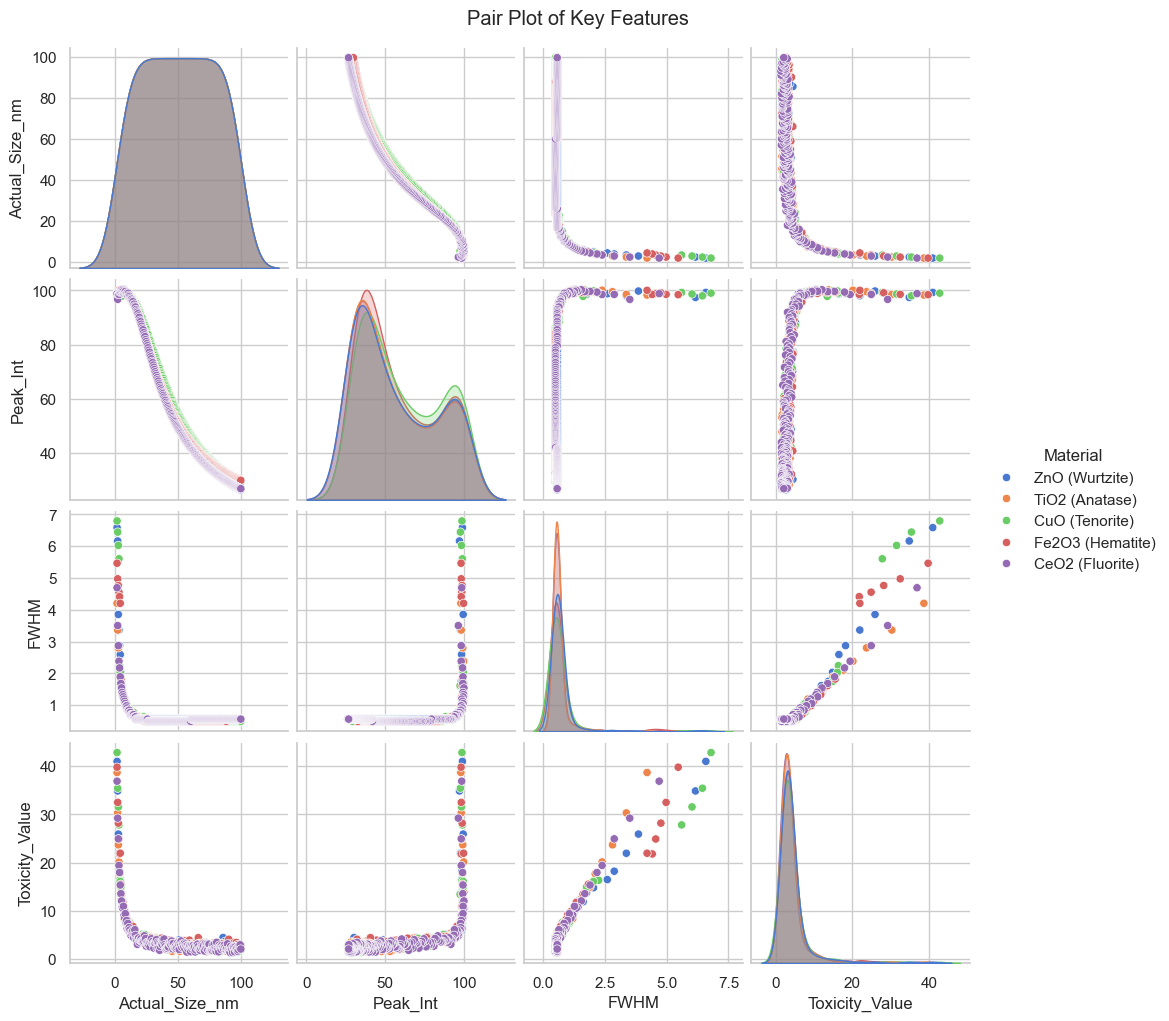

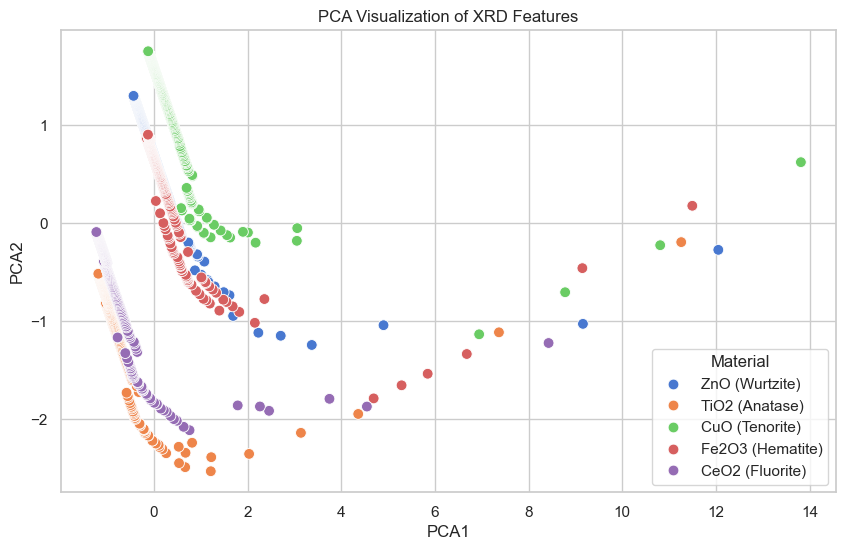

In [9]:
# 1. Visualizing Data Distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_final["Actual_Size_nm"], kde=True, color="blue")
plt.title("Distribution of Nanoparticle Size")

plt.subplot(1, 2, 2)
sns.boxplot(x="Material", y="Actual_Size_nm", data=df_final)
plt.xticks(rotation=45)
plt.title("Size Distribution by Material")
plt.tight_layout()
plt.savefig("XRD_Size_Distribution.png", dpi=300)
plt.show()

# 2. Correlation Analysis
plt.figure(figsize=(10, 8))
numeric_df = df_final.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig("XRD_Feature_Correlation.png", dpi=300)
plt.show()

# 3. Pair Plot
pair_cols = ["Actual_Size_nm", "Peak_Int", "FWHM", REGRESSION_TARGET, "Material"]
plot_df = df_final[pair_cols].copy()
plot_df = plot_df.dropna()
g = sns.pairplot(plot_df, hue="Material")
g.fig.suptitle("Pair Plot of Key Features", y=1.02)
g.savefig("XRD_Pair_Plot.png", dpi=300)
plt.show()

# 4. PCA Visualization
X_pca = numeric_df.drop(["Actual_Size_nm", REGRESSION_TARGET], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_scaled)

df_final["PCA1"] = pca_results[:, 0]
df_final["PCA2"] = pca_results[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Material", data=df_final, s=60)
plt.title("PCA Visualization of XRD Features")
plt.savefig("XRD_PCA_Analysis.png", dpi=300)
plt.show()

## Phase 3c: Feature Preview

Pairwise relationships between key structural features and toxicity.

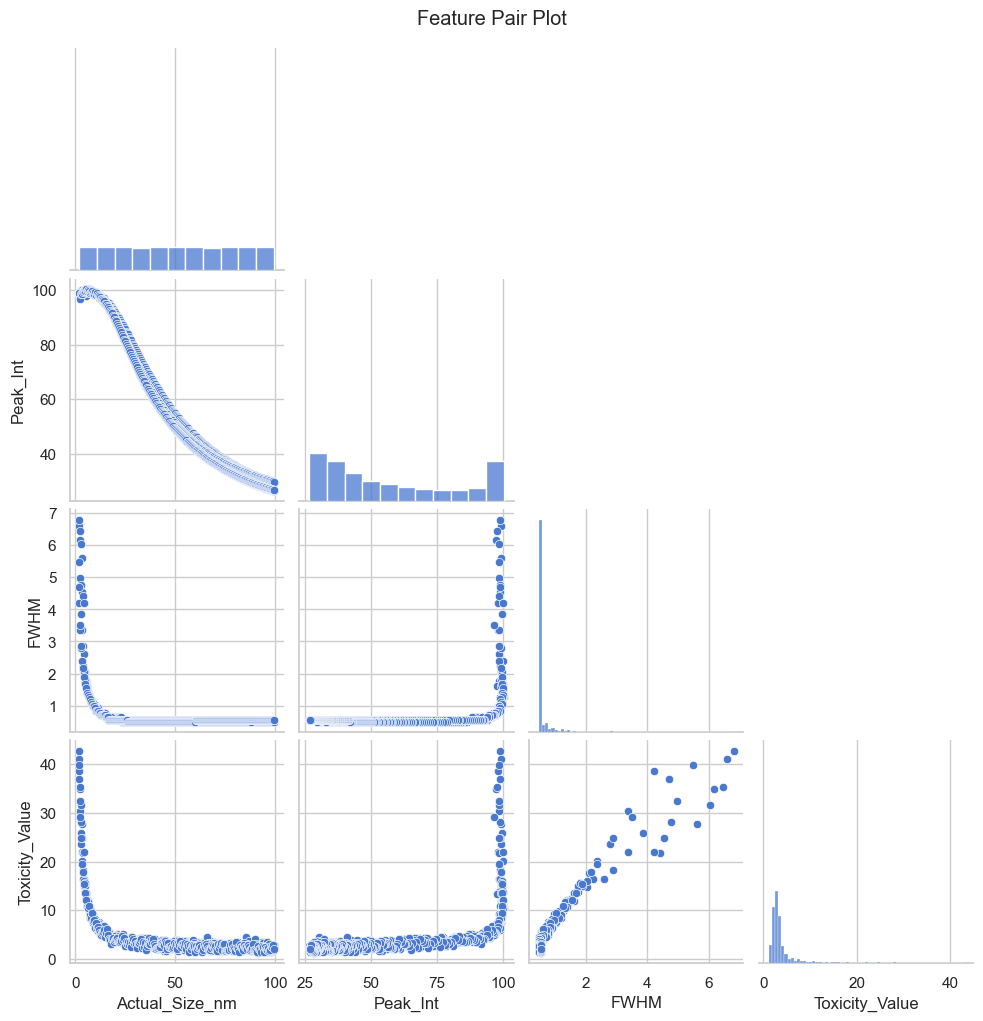

In [10]:
pair_cols = ["Actual_Size_nm", "Peak_Int", "FWHM", REGRESSION_TARGET]
plot_df = df_final[pair_cols].dropna()

sns.pairplot(plot_df, corner=True)
plt.suptitle("Feature Pair Plot", y=1.02)
plt.show()

## Phase 4: Model Development

Train regression or classification models depending on your target variable.

In [11]:
# Select features and targets (Paper-1 style)
X_reg = df_final[["Peak_Pos", "Peak_Int", "FWHM", "Num_Peaks"]]
y_reg = df_final["Actual_Size_nm"]

X_clf = df_final[["Peak_Pos", "Peak_Int", "FWHM", "Num_Peaks"]]
y_clf = df_final["Material"]

X_tox = df_final[["Peak_Pos", "Peak_Int", "FWHM", "Num_Peaks"]]
y_tox = df_final[REGRESSION_TARGET]

print("Feature matrix shape:", X_tox.shape)

Feature matrix shape: (980, 4)


In [12]:
# 1. Predicting Size (Regression)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_SEED
)

size_model = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED)
size_model.fit(X_train_r, y_train_r)

y_pred_r = size_model.predict(X_test_r)
print(f"Size Prediction MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f} nm")

# 2. Predicting Material Phase (Classification)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_SEED
)

class_model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
class_model.fit(X_train_c, y_train_c)

y_pred_c = class_model.predict(X_test_c)
acc = (y_pred_c == y_test_c).mean()
print(f"Phase Identification Accuracy: {acc * 100:.2f}%")

# 3. Predicting Toxicity (Regression)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tox, y_tox, test_size=0.2, random_state=RANDOM_SEED
)

tox_model = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED)
tox_model.fit(X_train_t, y_train_t)

y_pred_t = tox_model.predict(X_test_t)
print(f"Toxicity Prediction MAE: {mean_absolute_error(y_test_t, y_pred_t):.2f}")

Size Prediction MAE: 0.42 nm


Phase Identification Accuracy: 100.00%


Toxicity Prediction MAE: 0.55


## Phase 4b: Model Evaluation & Interpretation

We evaluate the model on a holdout set and inspect feature importance to interpret structural drivers of toxicity.

--- Toxicity Regression Evaluation ---
MAE: 0.5479695393416809
RMSE: 0.8361772986464211
R2: 0.962575875769473


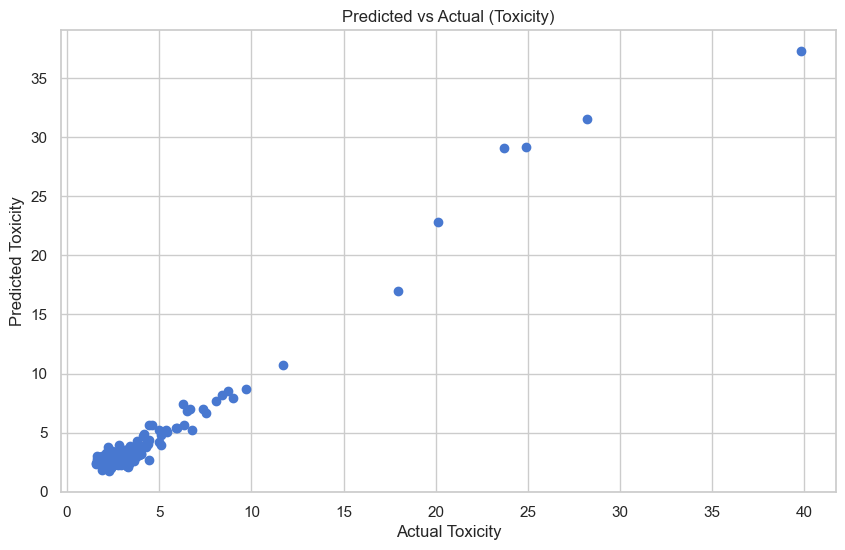

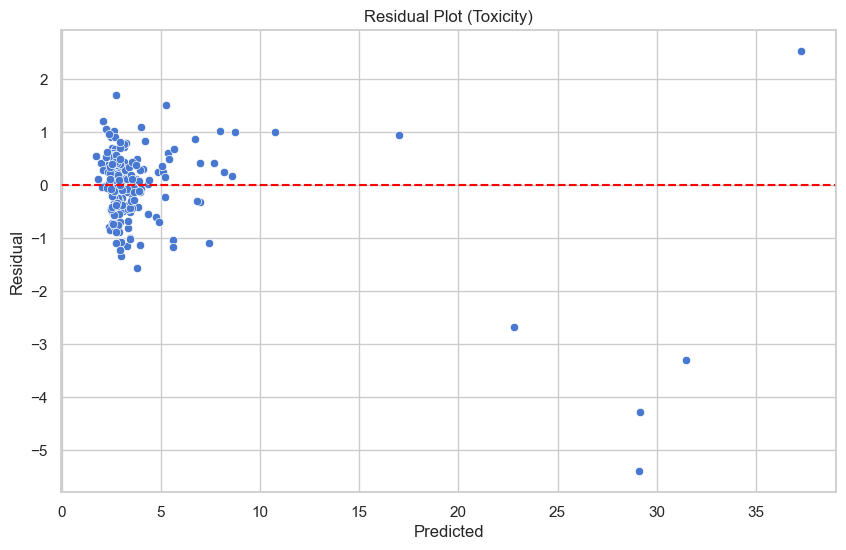


--- Material Phase Classification ---
                  precision    recall  f1-score   support

 CeO2 (Fluorite)       1.00      1.00      1.00        32
  CuO (Tenorite)       1.00      1.00      1.00        41
Fe2O3 (Hematite)       1.00      1.00      1.00        45
  TiO2 (Anatase)       1.00      1.00      1.00        46
  ZnO (Wurtzite)       1.00      1.00      1.00        32

        accuracy                           1.00       196
       macro avg       1.00      1.00      1.00       196
    weighted avg       1.00      1.00      1.00       196



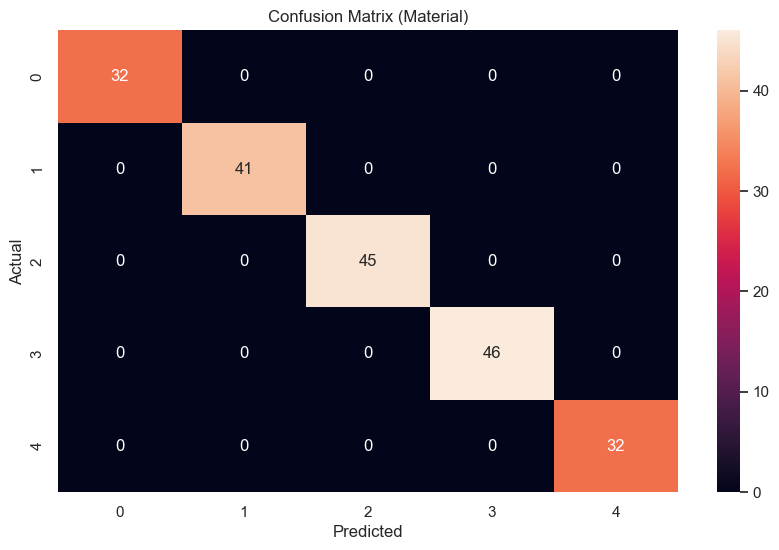

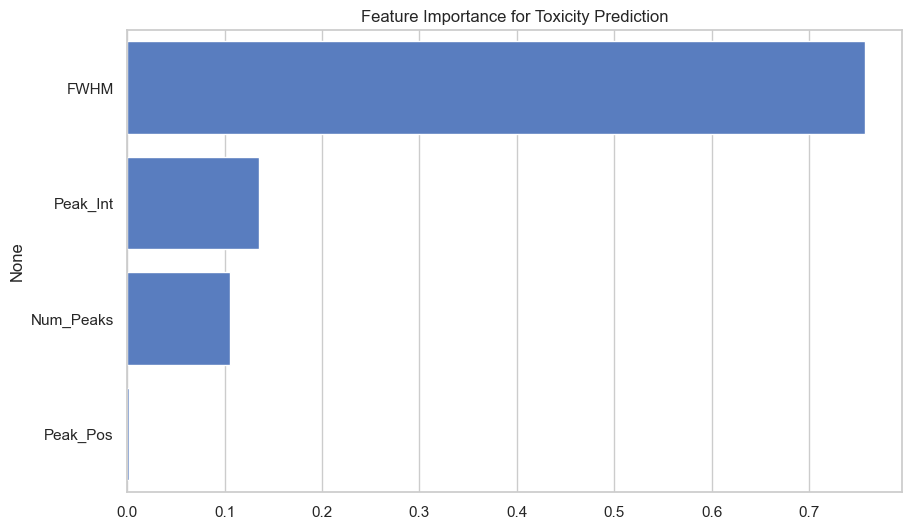

In [13]:
# --- Regression Evaluation (Toxicity) ---
print("--- Toxicity Regression Evaluation ---")
print("MAE:", mean_absolute_error(y_test_t, y_pred_t))
print("RMSE:", np.sqrt(mean_squared_error(y_test_t, y_pred_t)))
print("R2:", r2_score(y_test_t, y_pred_t))

plt.scatter(y_test_t, y_pred_t)
plt.xlabel("Actual Toxicity")
plt.ylabel("Predicted Toxicity")
plt.title("Predicted vs Actual (Toxicity)")
plt.savefig("ML_Actual_vs_Predicted_Toxicity.png", dpi=300)
plt.show()

residuals = y_test_t - y_pred_t
sns.scatterplot(x=y_pred_t, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot (Toxicity)")
plt.show()

# --- Classification Evaluation (Material Phase) ---
print("\n--- Material Phase Classification ---")
print(classification_report(y_test_c, y_pred_c))
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix (Material)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("ML_Confusion_Matrix_Material.png", dpi=300)
plt.show()

# --- Feature Importance (Toxicity Model) ---
importances = pd.Series(tox_model.feature_importances_, index=X_tox.columns).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance for Toxicity Prediction")
plt.savefig("ML_Feature_Importance_Toxicity.png", dpi=300)
plt.show()

## **Phase 5: Toxicity Insights & Visualization**

Summarize how the model links XRD structural features to toxicity, and highlight which characteristics are most predictive of safer nanoparticles.

**Examples:**
- Smaller crystallite sizes (broader peaks) often correlate with higher toxicity.
- Higher FWHM may indicate strain/defects that increase biological reactivity.
- Materials with fewer dominant peaks may show more stable phases and lower toxicity.

> Add your study-specific interpretations here after reviewing feature importance.

## Data Source Reminder

This notebook **generates all training data from Pymatgen structures** (no external CSV needed). If you want to replace the synthetic labels with real nanotoxicity data later, add a CSV and merge it to `df_final` by `Material` or a unique ID.